In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/vituri/Documentos/GitHub/TDA_workshop_EBT2024"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
# read meshes and plot
using Meshes, GeoIO
import GLMakie as gl

# see progress
using ProgressMeter

# dataframes
using DataFramesMeta, CSV, Chain

# metric spaces and graphs
using MetricSpaces
using Graphs, SimpleWeightedGraphs

# persistent homology
import Ripserer
import PersistenceDiagrams as Pd
import Plots

# comparing the distance matrix
using Clustering, StatsPlots
import StatisticalMeasures.ConfusionMatrices as CM

In [3]:
#| code-fold: true
function list_files(path="", pattern="")
    files =
        @chain begin
            map(walkdir(path)) do (root, dirs, files)
                joinpath.(root, files)
            end
            reduce(vcat, _)
            filter(x -> occursin(pattern, x), _)
        end

    files
end;

function get_class_files(class)
    @chain begin list_files("meshes/", class)
        filter(x -> occursin(".obj", x), _)
    end
end;

read_mesh(filepath) = GeoIO.load(filepath).geometry;

plot_mesh(ms) = viz(ms, showfacets = true, alpha = 0.5);

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


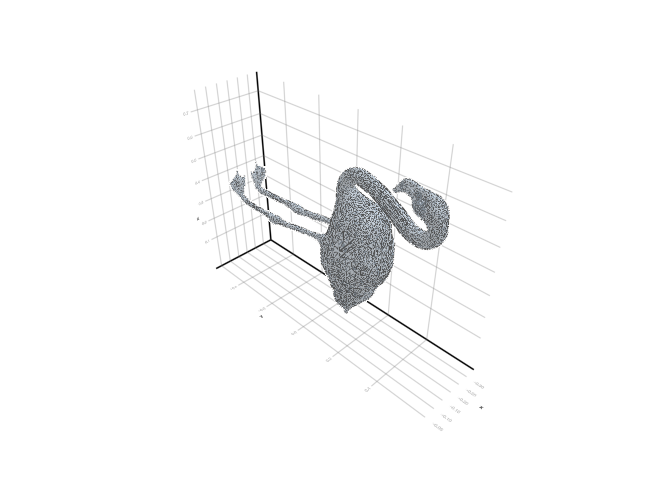

In [4]:
filepath = "meshes/flamingo-poses/flam-reference.obj"
ms = read_mesh(filepath)
plot_mesh(ms)

In [5]:
#| eval: false

# fig, ax, plt = plot_mesh(ms);

# gl.record(fig, "images/3d-shapes/flamingo.gif", 0:63) do i
#     gl.rotate!(fig.scene, Vec3f(0, 0, 1), i * pi/32)
# end;

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


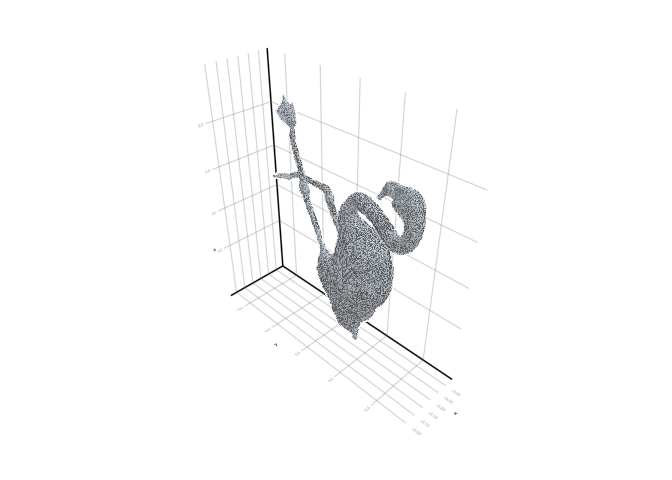

In [6]:
ms2 = read_mesh("meshes/flamingo-poses/flam-01.obj")

plot_mesh(ms2)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


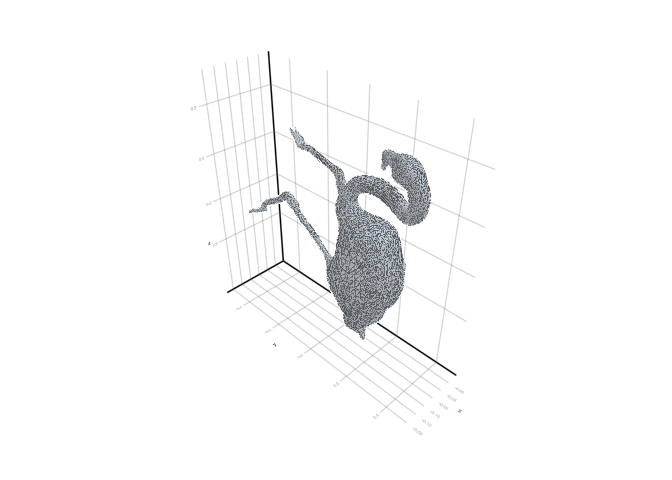

In [7]:
ms2 = read_mesh("meshes/flamingo-poses/flam-02.obj")

plot_mesh(ms2)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


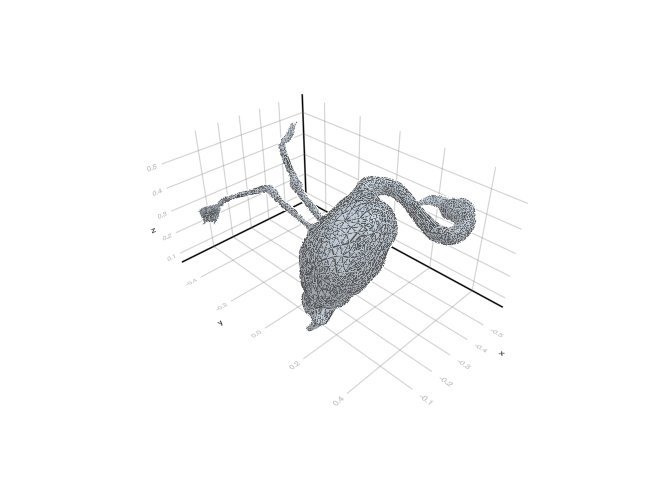

In [8]:
ms2 = read_mesh("meshes/flamingo-poses/flam-03.obj")

plot_mesh(ms2)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


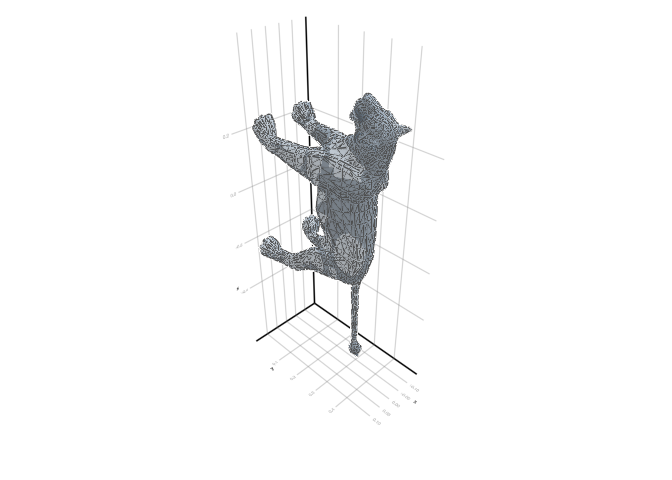

In [9]:
ms2 = read_mesh("meshes/lion-poses/lion-reference.obj")

plot_mesh(ms2)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


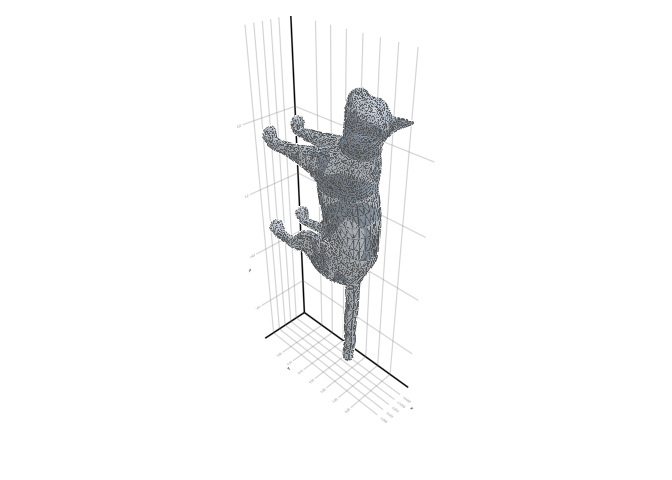

In [10]:
ms2 = read_mesh("meshes/cat-poses/cat-reference.obj")

plot_mesh(ms2)

In [11]:
#| code-fold: true
function plot_entire_class(class) 
    files = get_class_files(class)
    fig = gl.Figure(size = (800, 1200));

    for (i, file) ∈ enumerate(files)
        p, q = divrem(i - 1, 3) .+ 1    
        ms = read_mesh(file)
        viz(fig[p, q], ms, title = "a")    
    end

    fig
end;

function create_gif_entire_class(class)
    fig = plot_entire_class(class)

    gl.record(fig, "images/3d-shapes/" * class * ".gif", 0:63) do i
        gl.rotate!(fig.scene, Vec3f(0, 0, 1), i * pi/32)
    end
end;

In [12]:
#| code-fold: true

# all_classes = [
#     "camel", "cat", "elephant", "face"
#     , "flamingo", "head", "horse", "lion"
#     ]

# map(create_gif_entire_class, all_classes)

In [13]:
filter(!isfile, readdir("meshes/", join = true))

8-element Vector{String}:
 "meshes/camel-poses"
 "meshes/cat-poses"
 "meshes/elephant-poses"
 "meshes/face-poses"
 "meshes/flamingo-poses"
 "meshes/head-poses"
 "meshes/horse-poses"
 "meshes/lion-poses"

In [14]:
mesh_to_metric_space(ms) = ms.vertices .|> coordinates .|> Vector |> EuclideanSpace;

In [15]:
X = mesh_to_metric_space(ms)

26907-element Vector{StaticArraysCore.SVector{3, Float64}}:
 [-0.0497887, 0.179158, 0.304686]
 [-0.0478521, 0.176355, 0.337555]
 [-0.0489072, 0.170843, 0.36641]
 [-0.0479558, 0.154587, 0.319926]
 [-0.0484908, 0.148718, 0.356395]
 [-0.0549708, 0.129732, 0.300859]
 [-0.0529351, 0.125235, 0.325443]
 [-0.0537256, 0.124306, 0.346663]
 [-0.0569744, 0.201286, 0.371339]
 [-0.0536567, 0.19095, 0.297565]
 [-0.0522451, 0.191074, 0.306529]
 [-0.0571656, 0.181709, 0.282749]
 [-0.0524422, 0.185973, 0.296856]
 ⋮
 [-0.209925, 0.44, 0.658976]
 [-0.20707, 0.420017, 0.655563]
 [-0.210662, 0.444178, 0.660018]
 [-0.211038, 0.441635, 0.658588]
 [-0.208734, 0.420334, 0.651864]
 [-0.211586, 0.429432, 0.654244]
 [-0.210811, 0.425791, 0.653265]
 [-0.210709, 0.423044, 0.649643]
 [-0.211377, 0.439884, 0.657541]
 [-0.211205, 0.437203, 0.65695]
 [-0.211346, 0.434063, 0.656262]
 [-0.212218, 0.433793, 0.654967]

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


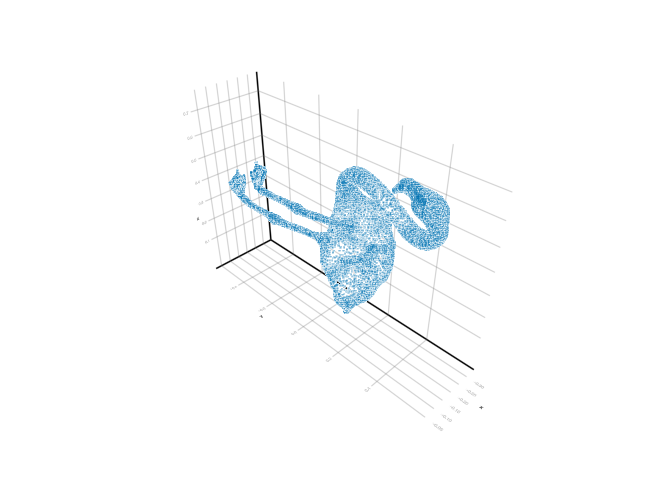

In [16]:
gl.scatter(X, markersize = 1)

In [17]:
#| code-fold: true
function graph_from_mesh(ms)
    # the set of vertices
    V = coordinates.(ms.vertices)

    # create an empty graph
    g = SimpleWeightedGraph()

    # add n vertices to it
    n = length(V)
    add_vertices!(g, n)

    # the set of triangles of the mesh ms
    triangles = ms.topology.connec

    # for each triangle, add its edges to the graph
    @showprogress desc = "Adding vertices to graph..." for t ∈ triangles
        v1, v2, v3 = t.indices
        add_edge!(g, v1, v2, dist_euclidean(V[v1], V[v2]))
        add_edge!(g, v1, v3, dist_euclidean(V[v1], V[v3]))
        add_edge!(g, v2, v3, dist_euclidean(V[v2], V[v3]))
    end

    g
end;

In [18]:
g = graph_from_mesh(ms)

Adding vertices to graph...   0%|                        |  ETA: 1:34:32

Adding vertices to graph... 100%|████████████████████████| Time: 0:00:01


{26907, 79244} undirected simple Int64 graph with Float64 weights

In [19]:
weights(g)

26907×26907 SparseArrays.SparseMatrixCSC{Float64, Int64} with 158488 stored entries:
⎡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣶⣶⣖⣆⣀⡀⢀⡀⠀⠀⠀⠀⠀⠀⠀⠤⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠈⢋⠛⠿⡿⣿⣿⣾⣆⣀⡀⠀⠀⠀⠀⠀⠉⠛⠿⢤⡀⠀⠀⠈⠁⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠛⠻⠿⠷⠷⣦⣀⡀⠀⠀⠀⠀⠀⠉⠙⠂⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠒⠠⠠⠄⡀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠛⠳⢤⣄⣀⠀⠀⠀⠐⢦⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠐⠒⠀⠀⠀⠀⠀⠀⢀⡀⠀⠈⠉⠛⠳⠶⣤⣈⠙⎥
⎢⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠰⣦⣤⣠⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠁⠈⠉⠂⠀⠀⠀⠉⠛⎥
⎢⢻⣿⡀⠀⠀⠀⠀⠀⠀⠀⠀⣻⣿⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢸⢿⡦⢀⠀⠀⢠⠀⠀⠀⠀⠐⠛⢿⢿⣷⣷⡤⡄⢐⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠈⢹⣿⡄⠀⠀⠀⡂⠀⠀⠀⠀⠀⠀⠙⡿⣿⣿⣷⣾⣄⢀⡀⠀⠀⠀⠀⠀⠀⠀⠑⣖⠂⠀⠀⠀⠀⠀⠂⠀⎥
⎢⠀⢈⣿⣯⡀⠀⠀⠡⡀⠀⠀⠀⠀⠀⢀⢉⣹⣿⣿⣿⣼⣕⣀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢷⡄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠈⣻⣿⣷⠀⠀⠀⢃⠀⠀⠀⠀⠀⠀⠀⠀⢙⢖⢿⣿⣿⣧⣲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠸⣄⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠈⢹⣿⡆⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠘⢩⣻⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠹⣧⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⢽⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠙⢿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠃⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠈⢻⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠻⣦⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⢧⠀⠀⠀⠈⣧⠀⠀⢀⠀⠀⠈⠘⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠻⣦⡄⠀⠀⠀⠀⠀⠀⢀⠀⠀⎥
⎢⠀⠈⣧⠀⠀⠀⠙⣆⠀⠈⠆⠀⠀⠀⠀⠉⢱⢤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠻⣦⡀⠀⠀⠀⠀⠘⢲⠀⎥
⎢⠀⠀⠛⣇⠀⠀⠀⢹⡆⠀⡆⠀⠀⠀⠀⠀⠈⠀⠙⠷⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⢰⣀⎥
⎢⠀⠀⠀⠈⣇⠀⠀⠀⢿⡀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠷⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠿⣧⣀⠀⠀⠙⎥
⎢⠀⠀⡀⠀⠈⠀⢀⠀⠘⣧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠀⠀⠀⠀⢀⣀⠀⠀⠀⠀⠘⠻⣦⡀⠀⎥
⎣⠀⠀⠁⠀⠀⠀⠈⠓⣆⠘⣧⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠒⠐⢲⣄⠀⠀⠈⠻⣦⎦

In [20]:
is_connected(g)

false

In [21]:
connected_components(g)

514-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  26898, 26899, 26900, 26901, 26902, 26903, 26904, 26905, 26906, 26907]
 [4032]
 [4036]
 [4039]
 [4042]
 [4046]
 [4047]
 [4048]
 [4049]
 [4050]
 [4077]
 [4099]
 [4100]
 ⋮
 [7089]
 [7090]
 [7091]
 [7092]
 [7093]
 [7094]
 [7095]
 [7096]
 [7097]
 [7098]
 [7099]
 [7100]

In [22]:
#| code-fold: true

function extract_biggest_connected_component(g)
    cc_components = connected_components(g)
    ids_biggest_component = cc_components[findmax(length, cc_components)[2]]

    # modify the graph g on place
    g = g[ids_biggest_component]

    # return g and the ids of the biggest connected component
    g, ids_biggest_component
end;

In [23]:
g, ids_biggest_component = extract_biggest_connected_component(g);

In [24]:
is_connected(g)

true

In [25]:
X = X[ids_biggest_component]

26394-element Vector{StaticArraysCore.SVector{3, Float64}}:
 [-0.0497887, 0.179158, 0.304686]
 [-0.0478521, 0.176355, 0.337555]
 [-0.0489072, 0.170843, 0.36641]
 [-0.0479558, 0.154587, 0.319926]
 [-0.0484908, 0.148718, 0.356395]
 [-0.0549708, 0.129732, 0.300859]
 [-0.0529351, 0.125235, 0.325443]
 [-0.0537256, 0.124306, 0.346663]
 [-0.0569744, 0.201286, 0.371339]
 [-0.0536567, 0.19095, 0.297565]
 [-0.0522451, 0.191074, 0.306529]
 [-0.0571656, 0.181709, 0.282749]
 [-0.0524422, 0.185973, 0.296856]
 ⋮
 [-0.209925, 0.44, 0.658976]
 [-0.20707, 0.420017, 0.655563]
 [-0.210662, 0.444178, 0.660018]
 [-0.211038, 0.441635, 0.658588]
 [-0.208734, 0.420334, 0.651864]
 [-0.211586, 0.429432, 0.654244]
 [-0.210811, 0.425791, 0.653265]
 [-0.210709, 0.423044, 0.649643]
 [-0.211377, 0.439884, 0.657541]
 [-0.211205, 0.437203, 0.65695]
 [-0.211346, 0.434063, 0.656262]
 [-0.212218, 0.433793, 0.654967]

In [26]:
ids_fps = farthest_points_sample(X, 400);
X_fps = X[ids_fps]

Progress:   1%|▎                                        |  ETA: 0:01:01

Progress:  26%|██████████▌                              |  ETA: 0:00:01

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


400-element Vector{StaticArraysCore.SVector{3, Float64}}:
 [-0.0571656, 0.181709, 0.282749]
 [-0.27207, -0.467607, 0.405263]
 [-0.19524, 0.483658, 0.681666]
 [-0.186904, 0.102347, 0.636425]
 [-0.245108, -0.119327, 0.32802]
 [-0.184687, 0.117032, 0.0062606]
 [-0.317797, 0.153405, 0.389586]
 [-0.120312, -0.316822, 0.314411]
 [-0.143379, 0.273049, 0.483562]
 [-0.251461, 0.212129, 0.194269]
 [-0.13464, 0.0781319, 0.433355]
 [-0.180646, 0.454526, 0.49867]
 [-0.0878225, -0.468109, 0.404058]
 ⋮
 [-0.26411, 0.17368, 0.498988]
 [-0.242208, 0.0933468, 0.460971]
 [-0.0825025, 0.0842934, 0.360014]
 [-0.209353, 0.0955674, 0.12523]
 [-0.205003, 0.470252, 0.55982]
 [-0.255032, 0.266761, 0.398051]
 [-0.10459, 0.120896, 0.200534]
 [-0.270267, 0.154275, 0.182703]
 [-0.213074, 0.0929044, 0.545403]
 [-0.279978, 0.129435, 0.448919]
 [-0.246899, 0.030022, 0.34624]
 [-0.153003, 0.124265, 0.626065]

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


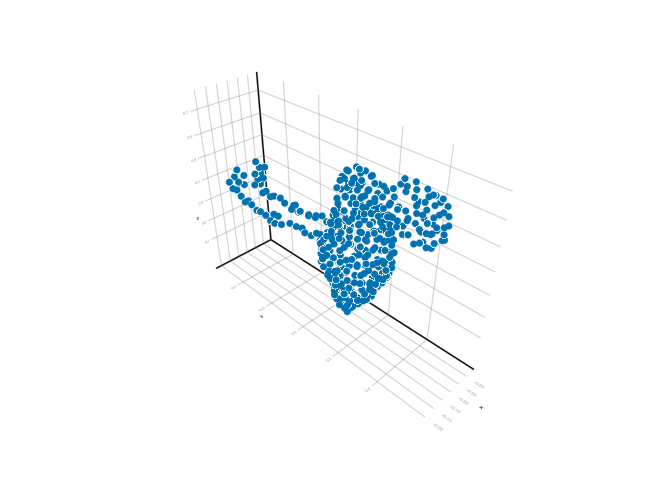

In [27]:
gl.scatter(X_fps, markersize = 10)

In [28]:
#| code-fold: true

function geodesic_distance_from_graph(g, ids)
    n = length(ids)
    D = zeros(n, n)

    # for each point, calculate the distance from it to every other point of g
    @showprogress desc = "Calculating geodesic distance..." Threads.@threads for (i, id) ∈ collect(enumerate(ids))
        dts = dijkstra_shortest_paths(g, id)
        D[i, :] = dts.dists[ids]
    end

    # force simmetry on X, because of small difference
    # in the calculation of paths
    for i ∈ 1:n
        for j ∈ i:n
            D[i, j] = D[j, i]
        end
    end

    # normalize the distance so the max is 1
    max_dist = maximum(D)
    D = D ./ max_dist

    return D
end;

In [29]:
D = geodesic_distance_from_graph(g, ids_fps)

Calculating geodesic distance...   0%|▏                  |  ETA: 0:00:40

Calculating geodesic distance...   3%|▋                  |  ETA: 0:00:09

Calculating geodesic distance...   6%|█▎                 |  ETA: 0:00:06

Calculating geodesic distance...   9%|█▊                 |  ETA: 0:00:05

Calculating geodesic distance...  12%|██▍                |  ETA: 0:00:04

Calculating geodesic distance...  15%|██▉                |  ETA: 0:00:04

Calculating geodesic distance...  18%|███▌               |  ETA: 0:00:04

Calculating geodesic distance...  21%|████               |  ETA: 0:00:04

Calculating geodesic distance...  24%|████▌              |  ETA: 0:00:03

Calculating geodesic distance...  27%|█████▏             |  ETA: 0:00:03

Calculating geodesic distance...  30%|█████▋             |  ETA: 0:00:03

Calculating geodesic distance...  33%|██████▎            |  ETA: 0:00:03

Calculating geodesic distance...  36%|██████▊            |  ETA: 0:00:03

Calculating geodesic distance...  38%|███████▎           |  ETA: 0:00:03

Calculating geodesic distance...  41%|███████▉           |  ETA: 0:00:02

Calculating geodesic distance...  44%|████████▍          |  ETA: 0:00:02

Calculating geodesic distance...  47%|█████████          |  ETA: 0:00:02

Calculating geodesic distance...  50%|█████████▌         |  ETA: 0:00:02

Calculating geodesic distance...  53%|██████████▏        |  ETA: 0:00:02

Calculating geodesic distance...  56%|██████████▊        |  ETA: 0:00:02

Calculating geodesic distance...  59%|███████████▎       |  ETA: 0:00:02

Calculating geodesic distance...  62%|███████████▉       |  ETA: 0:00:01

Calculating geodesic distance...  65%|████████████▍      |  ETA: 0:00:01

Calculating geodesic distance...  68%|█████████████      |  ETA: 0:00:01

Calculating geodesic distance...  71%|█████████████▌     |  ETA: 0:00:01

Calculating geodesic distance...  74%|██████████████     |  ETA: 0:00:01

Calculating geodesic distance...  76%|██████████████▌    |  ETA: 0:00:01

Calculating geodesic distance...  80%|███████████████▏   |  ETA: 0:00:01

Calculating geodesic distance...  82%|███████████████▋   |  ETA: 0:00:01

Calculating geodesic distance...  86%|████████████████▎  |  ETA: 0:00:01

Calculating geodesic distance...  88%|████████████████▉  |  ETA: 0:00:00

Calculating geodesic distance...  91%|█████████████████▍ |  ETA: 0:00:00

Calculating geodesic distance...  94%|█████████████████▉ |  ETA: 0:00:00

Calculating geodesic distance...  97%|██████████████████▍|  ETA: 0:00:00

Calculating geodesic distance... 100%|███████████████████| Time: 0:00:03


400×400 Matrix{Float64}:
 0.0        0.590388  0.590868   0.286544   …  0.278562   0.208754  0.264538
 0.590388   0.0       0.930305   0.604776      0.510596   0.398991  0.615194
 0.590868   0.930305  0.0        0.36874       0.460493   0.547859  0.345413
 0.286544   0.604776  0.36874    0.0           0.150158   0.228407  0.0433997
 0.298219   0.29517   0.642715   0.317335      0.220043   0.105971  0.327754
 0.222988   0.657519  0.790262   0.461005   …  0.33437    0.261972  0.463774
 0.305987   0.504961  0.510496   0.202736      0.0525786  0.110795  0.210621
 0.373959   0.715128  0.778582   0.456384      0.395873   0.335129  0.44897
 0.175699   0.671969  0.474419   0.190921      0.172539   0.286884  0.158314
 0.193838   0.591358  0.662487   0.358976      0.210089   0.192377  0.361567
 0.158373   0.500829  0.471957   0.15068    …  0.125385   0.128768  0.142345
 0.493517   0.835231  0.146586   0.278755      0.364869   0.452786  0.252473
 0.531877   0.871558  0.935012   0.612814      0.55

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


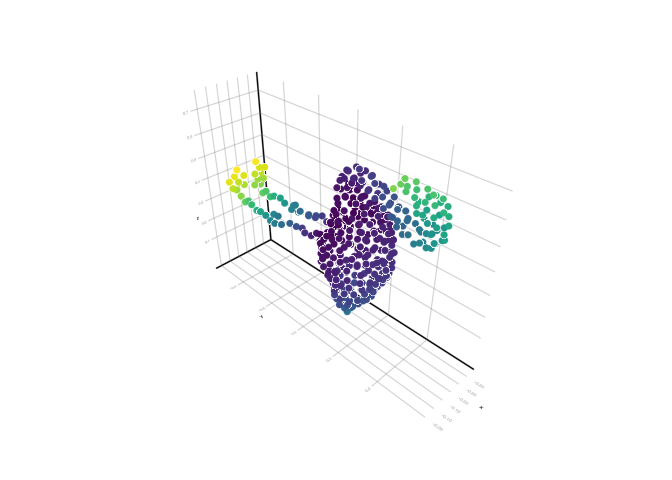

In [30]:
exc = map(sum, eachcol(D))

gl.scatter(X_fps, color = exc, markersize = 10)

In [31]:
pd = Ripserer.ripserer(D, dim_max = 2, verbose=true, sparse = true, threshold = 0.4)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/dMfiC/src/ProgressMeter.jl:594
Computing 2d intervals... 100%|█████████████████████████| Time: 0:00:06
  intervals:  14


Done. Time: 0:00:13


3-element Vector{PersistenceDiagrams.PersistenceDiagram}:
 400-element 0-dimensional PersistenceDiagram
 204-element 1-dimensional PersistenceDiagram
 14-element 2-dimensional PersistenceDiagram

In [32]:
#| code-fold: true

function plot_barcode(pd)
    # get the size of the longest interval
    threshold = 
        @chain begin
            vcat(pd...)
            last.(_)
            filter(isfinite, _)
            maximum
        end

    # plot the barcode using this interval as the maximum value of the x-axis
    Ripserer.barcode(pd, infinity = threshold)
end;

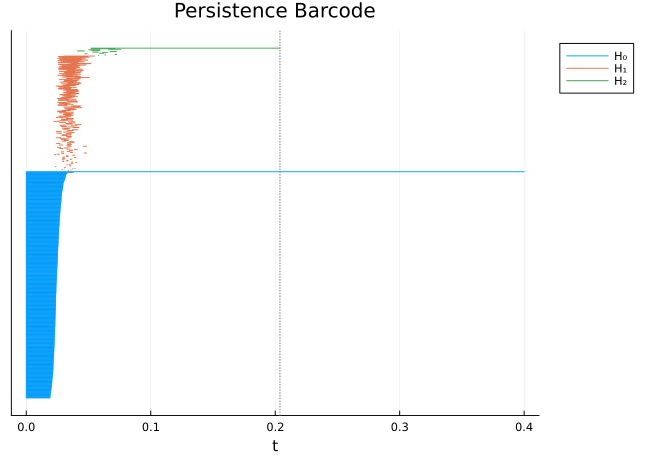

In [33]:
plot_barcode(pd)

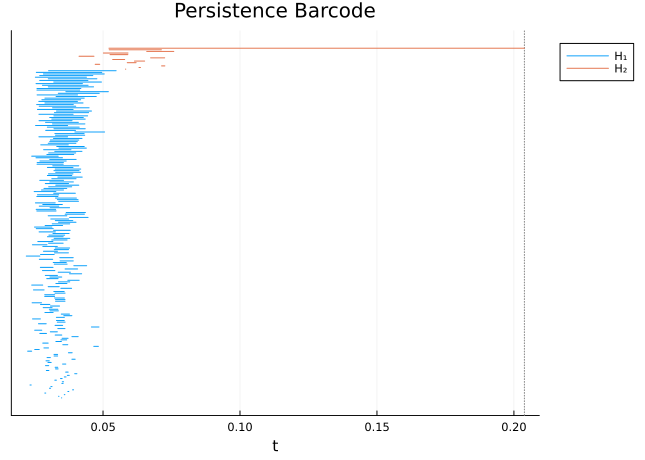

In [34]:
plot_barcode(pd[2:3])

In [35]:
#| code-fold: true

function file_to_barcode(filepath; n_points = 1000, dim_max = 1)
    ms = read_mesh(filepath)

    X = mesh_to_metric_space(ms)
    g = graph_from_mesh(ms)

    g, ids_biggest_component = extract_biggest_connected_component(g)
    X = X[ids_biggest_component]

    ids_fps = farthest_points_sample(X, n_points);
    X_fps = X[ids_fps]

    D = geodesic_distance_from_graph(g, ids_fps)

    pd = Ripserer.ripserer(D, dim_max = dim_max, verbose=true, sparse = true, threshold = 0.8)

    return X_fps, D, pd
end;

In [36]:
#| code-fold: true
function pd_to_dataframe(pd)
    df = @chain begin
        map(pd) do p
            DataFrame(
                birth=p .|> first, death=p .|> last, dim=p.dim
            )
        end
        vcat(_...)
    end

    df
end

function dataframe_to_pd(df)
    df.threshold .= 1

    @chain df begin
        groupby(:dim)
        collect
        map(Pd.PersistenceDiagram, _)
    end
end

function metric_space_to_df(X) 
    @chain X_fps begin
        stack
        transpose
        DataFrame(_, :auto)
    end
end

metric_space_to_df (generic function with 1 method)

In [37]:
#| eval: false
overwrite_old_files = true

@showprogress "Calculating barcode..." for file ∈ list_files("meshes/", ".obj") 
    println("Calculating barcode from file $file ...")

    file_pd = replace(file, ".obj" => "-pd.csv")
    # skip if there is a file already
    if isfile(file_pd) & !overwrite_old_files continue end

    X_fps, D, pd = file_to_barcode(file, n_points = 350, dim_max = 2)
    df = pd_to_dataframe(pd)

    CSV.write(file_pd, df)

    file_X = replace(file, ".obj" => "-points.csv")
    CSV.write(file_X, metric_space_to_df(X_fps))
end

In [38]:
#| code-fold: true

function throw_away_small_intervals(pd, min_pers = 0.01)
    map(pd) do p
        filter(x -> Pd.persistence(x) > min_pers, p)
    end
end;

function read_pds_from_files(directory, min_interval_size = 0.05)
  pds_df = DataFrame()

#   file = list_files("meshes/", "-pd.csv")[1]
  for file ∈ list_files(directory, "-pd.csv")

      pd = @chain begin
          CSV.read(file, DataFrame)
          dataframe_to_pd(_)
          throw_away_small_intervals(min_interval_size)
      end

      name = replace(file, "-pd.csv" => "")
      push!(pds_df, (Path = name, Persistence_diagram = pd))
  end

  pds_df

  sort!(pds_df, :Path)

  pds_df.File = [split(s, "/")[3] for s ∈ pds_df.Path]
  pds_df.Class = [split(s, "-")[1] for s ∈ pds_df.File]

  pds_df
end;

In [39]:
pds_df = read_pds_from_files("meshes/", 0.01)

Row,Path,Persistence_diagram,File,Class
,String,Array…,SubStrin…,SubStrin…
1,meshes/camel-poses/camel-01,"PersistenceDiagram[350-element 0-dimensional PersistenceDiagram, 64-element 1-dimensional PersistenceDiagram, 2-element 2-dimensional PersistenceDiagram]",camel-01,camel
2,meshes/camel-poses/camel-02,"PersistenceDiagram[350-element 0-dimensional PersistenceDiagram, 62-element 1-dimensional PersistenceDiagram, 5-element 2-dimensional PersistenceDiagram]",camel-02,camel
3,meshes/camel-poses/camel-03,"PersistenceDiagram[350-element 0-dimensional PersistenceDiagram, 79-element 1-dimensional PersistenceDiagram, 2-element 2-dimensional PersistenceDiagram]",camel-03,camel
4,meshes/camel-poses/camel-04,"PersistenceDiagram[350-element 0-dimensional PersistenceDiagram, 75-element 1-dimensional PersistenceDiagram, 3-element 2-dimensional PersistenceDiagram]",camel-04,camel
5,meshes/camel-poses/camel-05,"PersistenceDiagram[350-element 0-dimensional PersistenceDiagram, 68-element 1-dimensional PersistenceDiagram, 2-element 2-dimensional PersistenceDiagram]",camel-05,camel
6,meshes/camel-poses/camel-06,"PersistenceDiagram[350-element 0-dimensional PersistenceDiagram, 71-element 1-dimensional PersistenceDiagram, 2-element 2-dimensional PersistenceDiagram]",camel-06,camel
7,meshes/camel-poses/camel-07,"PersistenceDiagram[350-element 0-dimensional PersistenceDiagram, 78-element 1-dimensional PersistenceDiagram, 4-element 2-dimensional PersistenceDiagram]",camel-07,camel
8,meshes/camel-poses/camel-08,"PersistenceDiagram[350-element 0-dimensional PersistenceDiagram, 73-element 1-dimensional PersistenceDiagram, 4-element 2-dimensional PersistenceDiagram]",camel-08,camel
9,meshes/camel-poses/camel-09,"PersistenceDiagram[350-element 0-dimensional PersistenceDiagram, 83-element 1-dimensional PersistenceDiagram, 5-element 2-dimensional PersistenceDiagram]",camel-09,camel


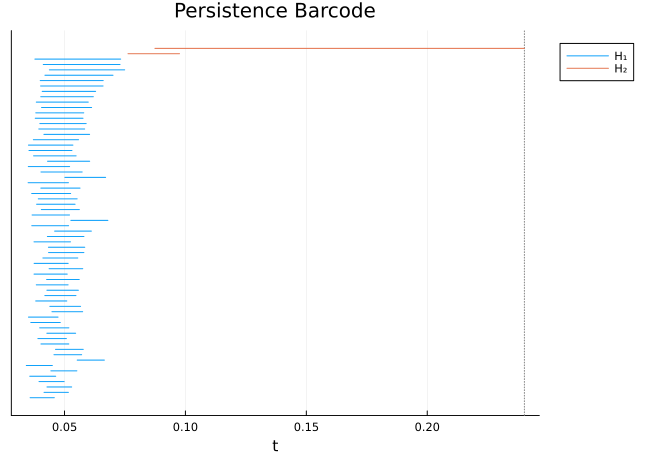

In [40]:
pd2 = pds_df.Persistence_diagram[1]
plot_barcode(pd2[2:3])

In [41]:
#| eval: false
pds = pds_df.Persistence_diagram

DB = zeros(83, 83)

@showprogress for i ∈ 1:83
    for j ∈ i:83
        if i == j
            DB[i, j] = 0 
            continue 
        end

        DB[i, j] = 
            Pd.Bottleneck()(pds[i][2], pds[j][2]) + 
            Pd.Bottleneck()(pds[i][3], pds[j][3])

        DB[j, i] = DB[i, j]
    end
end

CSV.write("meshes/bottleneck_distance.csv", DataFrame(DB, :auto))

In [42]:
DB = CSV.read("meshes/bottleneck_distance.csv", DataFrame) |> Matrix
DB

83×83 Matrix{Float64}:
 0.0        0.0295622  0.0290437  …  0.0607949  0.0572987  0.0555027
 0.0295622  0.0        0.0243571     0.0771963  0.0725624  0.0726897
 0.0290437  0.0243571  0.0           0.0751122  0.0706953  0.07074
 0.0250842  0.0221888  0.0246823     0.0699059  0.0653315  0.0658234
 0.0192733  0.0247452  0.0230421     0.0647476  0.062099   0.0607826
 0.0300337  0.0257192  0.014413   …  0.0729532  0.0680901  0.0688222
 0.0270758  0.0372715  0.0355232     0.0541806  0.0491843  0.0458797
 0.0239714  0.0229871  0.0240051     0.0654462  0.0644016  0.0613805
 0.0354928  0.0229931  0.0236201     0.0807913  0.0765014  0.0759065
 0.0282784  0.0247452  0.0209122     0.0744052  0.0719081  0.0700331
 0.0242075  0.0255816  0.0278271  …  0.0672653  0.0677038  0.0630916
 0.0671795  0.0780996  0.0795003     0.0520017  0.0460498  0.0740998
 0.0622585  0.076908   0.0745496     0.0303738  0.0299614  0.0425986
 ⋮                                ⋱  ⋮                     
 0.0565404  0.0753205 

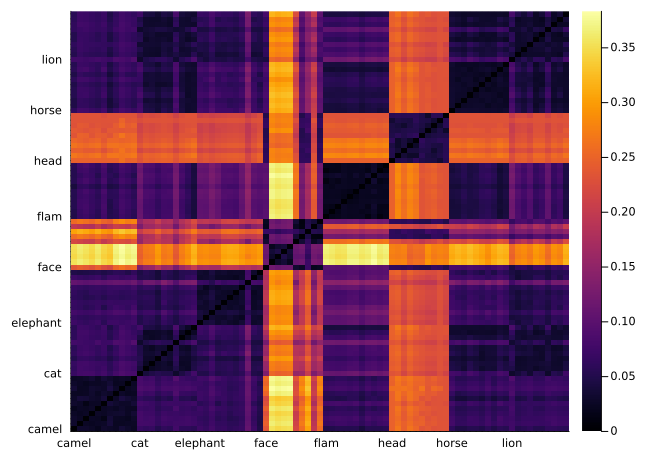

In [43]:
labels = pds_df.Class |> copy
for i ∈ 2:length(pds_df.Class)
    if labels[i] == pds_df.Class[i-1]
        labels[i] = ""
    end
end

labels = (1:83, labels)

plot(DB, st = :heatmap, xticks = labels, yticks = labels)

In [44]:
#| code-fold: true
function plot_hc(hc)
    plot(
        hc, xticks = (1:83, pds_df.File[hc.order])
        , xflip = true, xrotation = 270
        , xtickfont = font(5, "Roboto")
        )
end;

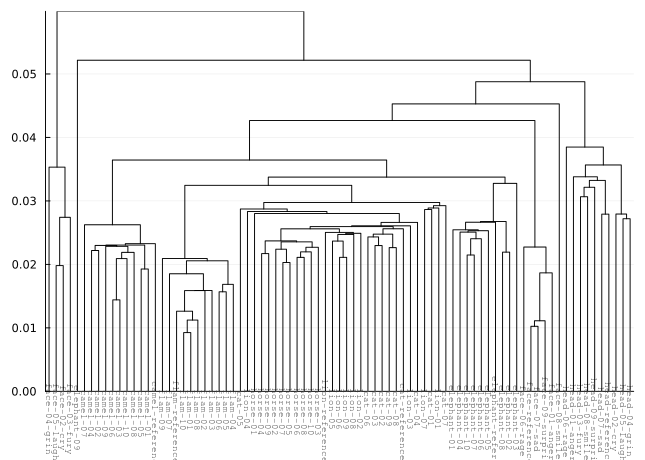

GKS: could not find font Roboto.ttf


In [45]:
hclust(DB, linkage=:single, branchorder = :optimal) |> plot_hc

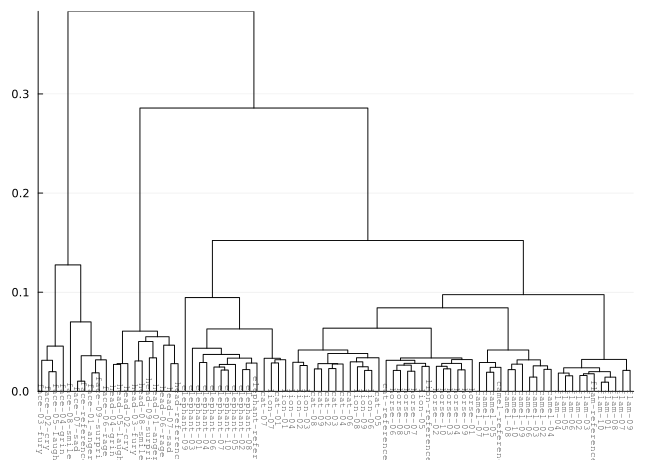

In [46]:
hclust(DB, linkage = :complete, branchorder = :optimal) |> plot_hc

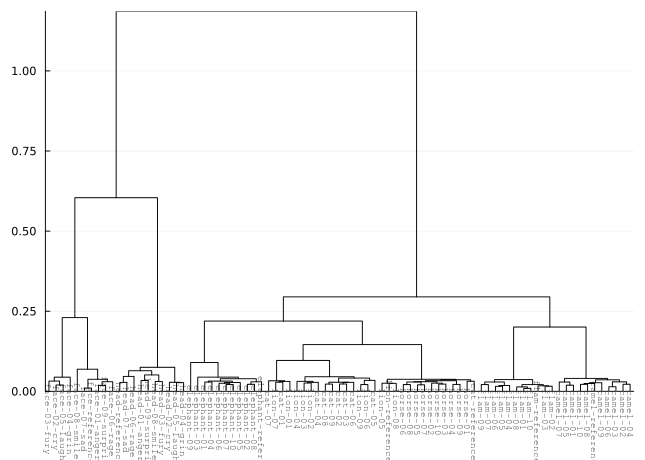

In [47]:
hclust(DB, linkage = :ward, branchorder = :optimal) |> plot_hc

In [48]:
#| code-fold: true
get_class_from_file(x) = split(x, "-")[1]

get_class_from_file (generic function with 1 method)

In [49]:
score = @select(pds_df, :Path, :File, :Class)

score.Nearest_class .= ""

ids_reference = findall(x -> occursin("-reference", x), score.Path)
names_reference = score.File[ids_reference]

for i ∈ 1:83
    id = sortperm(DB[i, ids_reference])[1]
    score.Nearest_class[i] = names_reference[id]
end

score

Row,Path,File,Class,Nearest_class
,String,SubStrin…,SubStrin…,String
1,meshes/camel-poses/camel-01,camel-01,camel,camel-reference
2,meshes/camel-poses/camel-02,camel-02,camel,camel-reference
3,meshes/camel-poses/camel-03,camel-03,camel,camel-reference
4,meshes/camel-poses/camel-04,camel-04,camel,camel-reference
5,meshes/camel-poses/camel-05,camel-05,camel,camel-reference
6,meshes/camel-poses/camel-06,camel-06,camel,camel-reference
7,meshes/camel-poses/camel-07,camel-07,camel,camel-reference
8,meshes/camel-poses/camel-08,camel-08,camel,camel-reference
9,meshes/camel-poses/camel-09,camel-09,camel,camel-reference


In [50]:
score.Right_class =
    get_class_from_file.(score.Class) .== 
    get_class_from_file.(score.Nearest_class)

83-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0
 0
 ⋮
 0
 0
 0
 0
 1
 0
 1
 1
 0
 1
 1
 1

In [51]:
score.Right_class |> mean

0.7228915662650602

In [52]:
score_new = @rsubset score !occursin("ref", :File)
x = CM.confmat(get_class_from_file.(score_new.Nearest_class), score_new.Class)

8×8 Matrix{Int64}:
 10  0   0  0   0  0  0  0
  0  1   0  0   0  0  1  0
  0  2  10  0   0  0  0  4
  0  0   0  9   0  1  0  0
  0  0   0  0  10  0  0  0
  0  0   0  0   0  8  0  0
  0  0   0  0   0  0  0  0
  0  6   0  0   0  0  9  5

In [53]:
# using MultivariateStats
# M = fit(MDS, DB; distances = true, maxoutdim = 3)
# Y = predict(M)

# score.Row = 1:length(score.Class)

# dfs = @chain score begin
#     groupby(:Class)
#     collect
# end

# fig = gl.Figure();
# ax = gl.Axis3(fig[1,1])

# for (i, df) ∈ enumerate(dfs)
    
#     gl.scatter!(ax, Y[:, df.Row], label = df.Class[1])
    
# end

# gl.axislegend();